## Non identifiable regression in variation inference
Consider a random variable $X \sim N(\gamma * \theta, 1)$ with the parameters $\gamma \in R$ and $\theta \in R$.


The problem is non-identifiable because we only care about the product $\gamma*\theta$, and hence we have infinitely many optimal solutions $\hat{\theta}, \hat{\gamma}$ s.t. $\hat{\theta}* \hat{\gamma} = \theta*\gamma = \mu$, where we have defined $\mu=\theta*\gamma$.

For example, if $\mu=2$ we get the following optimal lines when $-2<\gamma<2$ and $\gamma \neq 0$:

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


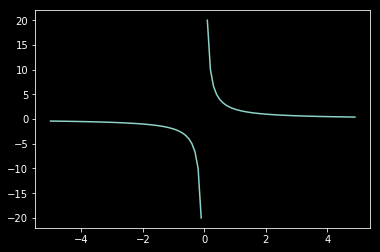

In [1]:
import numpy as np
import matplotlib.pyplot as plt
mu = 2
gamma = np.arange(-5.0,5, 0.1).round(2)
theta = mu/gamma
plt.plot(gamma, theta)

## Posterior distribution
We want to find the posterior distribution of X given some data $x_1, x_2, ..., x_n$.

We put improper flat priors on the parameters: $\gamma \sim 1$, $\theta \sim 1$.
The posterior distribution is then 

$$P(\theta, \gamma | x_1, .., x_n) \sim \prod_{i=1}^n N(x_i; \theta * \gamma, 1) = N(\mu; \frac{1}{n} \sum_{i=1}^n x_i, \frac{1}{\sqrt{n}}):= N(\mu; \bar{x}, \bar{ \sigma})$$

where the second equality is the result of multiplying i.i.d. gaussian pdfs, and the last is a definition.

So the product of $\gamma* \theta$ has a fixed posterior distribution, but they have an intricate dependency between each other.

## Find the posterior using MCMC

In [2]:
# Simulate some data
import torch
import pyro
import pyro.distributions as dist
n = 10
mu = 2
var = 1
x = dist.Normal(mu,var).sample((n,))
x_bar = x.mean()
sigma_bar = x.std()
x_bar, sigma_bar, var

(tensor(2.2676), tensor(1.1785), 1)

In [3]:
# Define the prior + likelihood using pyro in the model function model()
# We will aproximate the flat priors with uniform(-5,5)
def model(x):
    theta = pyro.sample("theta", dist.Uniform(-10,10))
    gamma = pyro.sample("gamma", dist.Uniform(-10,10))
    var = 1#pyro.sample("var", dist.Uniform(0,3))
    mu = theta*gamma
    mu, theta, gamma
    with pyro.plate("obs", size = n):
        obsdistr = dist.Normal(mu.repeat(n,),1) # var.repeat(n,)
        obs = pyro.sample("x", obsdistr, obs=x)
    return mu


from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model, step_size = 0.1, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(x)
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [02:00,  9.94it/s, step size=5.11e-02, acc. prob=0.742]


### Plot sample distributions of the parameters
We can inspect the posterior by plotting the distribution of $\hat{\mu}$, the marginal distributions of $\hat{\gamma}, \hat{\theta}$ and the joint distribution of the two.

As expected, we see the product distribution looks gaussian, the marginal looks ("quite") flat and the joint distribution has settled on one quadrant of the possible solution given above.

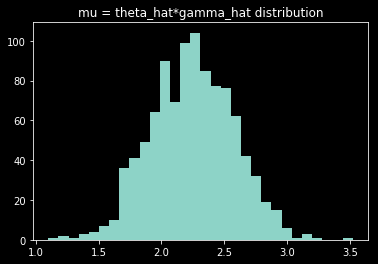

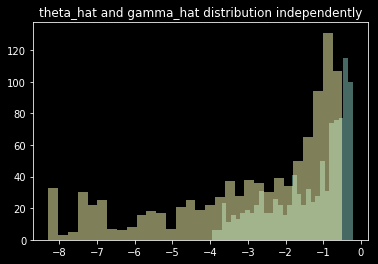

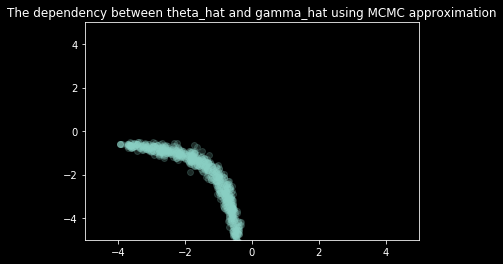

In [4]:
theta_hat = hmc_samples['theta']
gamma_hat = hmc_samples['gamma']
#var_hat = hmc_samples['var']
_ = plt.hist(theta_hat*gamma_hat, bins = 30)
plt.title("mu = theta_hat*gamma_hat distribution")
plt.show()

_ = plt.hist(theta_hat, bins = 30, alpha=0.5)
_ = plt.hist(gamma_hat, bins = 30, alpha=0.5)
#_ = plt.hist(var_hat, bins = 30, alpha=0.5)

_ = plt.title("theta_hat and gamma_hat distribution independently")
plt.show()

_ = plt.scatter(theta_hat, gamma_hat, alpha = 0.2)
plt.xlim(-5,5)
plt.ylim(-5,5)
_ = plt.title("The dependency between theta_hat and gamma_hat using MCMC approximation")

## Find posterior distribution using mean-field Variational Inference
We can use the same model() object defined above, but we need to introduce an approximate variational distribution in the guide.

In [20]:
from pyro.infer import SVI, Trace_ELBO
from torch.distributions import constraints
import pyro.optim as optim

rng = lambda: torch.rand((1,))[0]-0.5

def guide(x):
    param = {}
    distr = {}
    param['theta_mean'] = pyro.param("theta-mean", rng())
    param['theta_scale'] = pyro.param("theta-scale", 0.5 + rng(), constraint= constraints.positive)
    distr['theta'] = dist.Normal(param['theta_mean'], param['theta_scale'])
    pyro.sample("theta", distr['theta'])

    param['gamma_mean'] = pyro.param("gamma-mean", rng())
    param['gamma_scale'] = pyro.param("gamma-scale", rng()+0.5, constraint= constraints.positive)
    distr['gamma'] = dist.Normal(param['gamma_mean'],param['gamma_scale'])
    pyro.sample("gamma", distr['gamma'])

    #param['var_mean'] = pyro.param("var-mean", 3*rng())
    #param['var_scale'] = pyro.param("var-scale", rng()+0.5, constraint= constraints.positive)
    #distr['var'] = dist.Normal(param['var_mean'],param['var_scale'])
    #pyro.sample("var", distr['var'])
    return param, distr

In [6]:
from pyro.infer import SVI, Trace_ELBO
from torch.distributions import constraints
import pyro.optim as optim
import logging
pyro.clear_param_store()
svi = SVI(model,
          guide,
          optim.Adam({"lr": .05}),
          loss=Trace_ELBO())

#pyro.clear_param_store()
num_iters = 20000
for i in range(num_iters):
    elbo = svi.step(x)
    if i % 500 == 0:
        print(f"Elbo loss: {elbo:.2f}")



Elbo loss: 38.48
Elbo loss: 22.46
Elbo loss: 23.85
Elbo loss: 23.01
Elbo loss: 23.06
Elbo loss: 24.88
Elbo loss: 23.04
Elbo loss: 23.21
Elbo loss: 25.25
Elbo loss: 22.96
Elbo loss: 21.73
Elbo loss: 22.49
Elbo loss: 23.22
Elbo loss: 22.20
Elbo loss: 22.62
Elbo loss: 22.28
Elbo loss: 22.25
Elbo loss: 22.64
Elbo loss: 22.61
Elbo loss: 21.92
Elbo loss: 22.45
Elbo loss: 23.48
Elbo loss: 21.01
Elbo loss: 22.58
Elbo loss: 22.63
Elbo loss: 22.84
Elbo loss: 25.21
Elbo loss: 22.80
Elbo loss: 21.90
Elbo loss: 26.25
Elbo loss: 30.23
Elbo loss: 24.04
Elbo loss: 24.06
Elbo loss: 21.21
Elbo loss: 22.13
Elbo loss: 22.09
Elbo loss: 22.66
Elbo loss: 22.58
Elbo loss: 22.05
Elbo loss: 21.03


### Visualizing the Variational Inference plots
We may plot the same distributional graphs with VI as we did with the MCMC distribution:

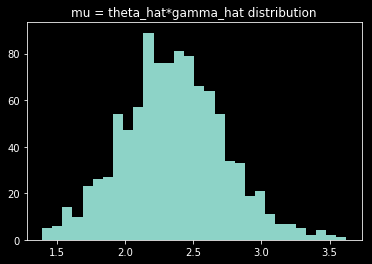

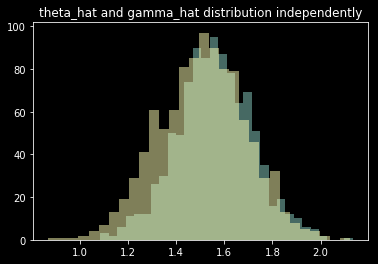

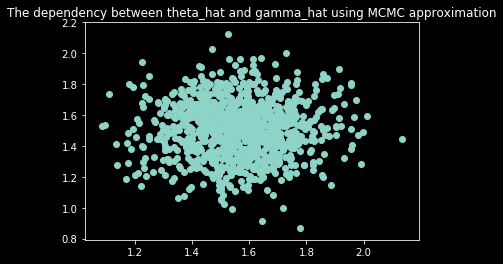

In [7]:
par, distr = guide(x)
samples = {key : distr.sample((1000,)) for key, distr in distr.items()}

theta_hat = samples['theta']
gamma_hat = samples['gamma']
#var_hat = samples['var']
_ = plt.hist(theta_hat*gamma_hat, bins = 30)
plt.title("mu = theta_hat*gamma_hat distribution")
plt.show()

_ = plt.hist(theta_hat, bins = 30, alpha=0.5)
_ = plt.hist(gamma_hat, bins = 30, alpha=0.5)
#_ = plt.hist(var_hat, bins = 30, alpha=0.5)
_ = plt.title("theta_hat and gamma_hat distribution independently")
plt.show()

_ = plt.scatter(theta_hat, gamma_hat)
#plt.xlim(-5,5)
#plt.ylim(-5,5)
_ = plt.title("The dependency between theta_hat and gamma_hat using MCMC approximation")

We see that the VI approximation is surprising good at modelling $\hat{\mu}$. The distribution looks surprising similar to the one found by MCMC.
The mode is shifted to the left, but that is actually closer to the true mean value(!).

However, the variational distribution completely breaks down in the marginal case, and only finds one "point" on the optimal line found by MCMC.
By starting the VI algorithm in different starting positions, it ends up in different points.


### Compare the VI solution vs MCMC solution

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



(-5, 5)

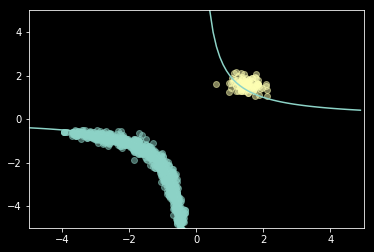

In [15]:
# Plot optimal solution as well:
mu = 2
gamma = np.arange(-5.0,5, 0.1).round(2)
theta = mu/gamma
plt.plot(gamma, theta)

for s in [hmc_samples, samples]:
    theta_hat = s['theta']
    gamma_hat = s['gamma']
    _ = plt.scatter(theta_hat, gamma_hat, alpha=0.5)
plt.xlim(-5,5)
plt.ylim(-5,5)


## Different starting points for VI
What happens with the VI solution for different starting points? We initialize the algorithm in different random points sampling the variational means from [-0.5, 0.5] and the scales from [0,1] uniformly.


---
run 0
Elbo loss: 52.30
Elbo loss: 19.57
Elbo loss: 22.36
Elbo loss: 22.96
Elbo loss: 24.09

---
run 1
Elbo loss: 41.64
Elbo loss: 21.79
Elbo loss: 23.84
Elbo loss: 22.22
Elbo loss: 22.59

---
run 2
Elbo loss: 45.04
Elbo loss: 22.67
Elbo loss: 21.70
Elbo loss: 25.11
Elbo loss: 22.78

---
run 3
Elbo loss: 44.71
Elbo loss: 22.94
Elbo loss: 22.62
Elbo loss: 22.35
Elbo loss: 23.22

---
run 4
Elbo loss: 49.46
Elbo loss: 22.69
Elbo loss: 22.82
Elbo loss: 22.08
Elbo loss: 20.66


Text(0.5, 1.0, 'The dependency between theta_hat and gamma_hat using VI approximation with different starting points (colours)')

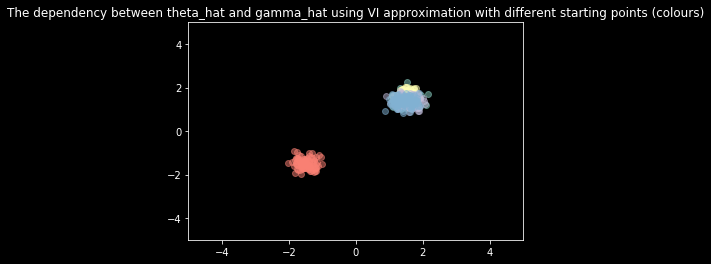

In [22]:
for run in range(5):
    print("")
    print("---")
    print(f"run {run}")
    svi = SVI(model,
          guide,
          optim.Adam({"lr": .05}),
          loss=Trace_ELBO())

    pyro.clear_param_store()
    num_iters = 5000
    for i in range(num_iters):
        elbo = svi.step(x)
        if i % 1000 == 0:
            print(f"Elbo loss: {elbo:.2f}")
    par, distr = guide(x)
    samples = {key : distr.sample((100,)) for key, distr in distr.items()}

    theta_hat = samples['theta']
    gamma_hat = samples['gamma']
    plt.scatter(theta_hat, gamma_hat, alpha = 0.5)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title("The dependency between theta_hat and gamma_hat using VI approximation with different starting points (colours)")

## What happens if you move the VI mean solution to a different point?
It seems like the VI solution always finds the solution that is closest to the origin.
Is this always optimal?

Could this be because the KL divergence will cover more of the true posterior if it converges to this point because this is the point of most curvature of the true solution?

Test:

1. Calculate KL-divergence at the full [-5,5]^2 grid.
2. make model curve more somehwere else (wip)?

In [10]:

# Optimize model (as above):
pyro.clear_param_store()
svi = SVI(model,
          guide,
          optim.Adam({"lr": .05}),
          loss=Trace_ELBO())

#pyro.clear_param_store()
num_iters = 20000
for i in range(num_iters):
    elbo = svi.step(x)
    if i % 500 == 0:
        print(f"Elbo loss: {elbo:.2f}")

Elbo loss: 43.44
Elbo loss: 24.13
Elbo loss: 22.89
Elbo loss: 22.61
Elbo loss: 22.61
Elbo loss: 22.19
Elbo loss: 23.08
Elbo loss: 22.65
Elbo loss: 26.59
Elbo loss: 22.55
Elbo loss: 22.75
Elbo loss: 23.97
Elbo loss: 21.00
Elbo loss: 22.38
Elbo loss: 22.65
Elbo loss: 23.01
Elbo loss: 22.25
Elbo loss: 22.25
Elbo loss: 22.82
Elbo loss: 23.56
Elbo loss: 22.66
Elbo loss: 23.40
Elbo loss: 22.94
Elbo loss: 21.80
Elbo loss: 21.49
Elbo loss: 22.38
Elbo loss: 23.02
Elbo loss: 25.07
Elbo loss: 22.45
Elbo loss: 23.84
Elbo loss: 22.43
Elbo loss: 21.81
Elbo loss: 22.79
Elbo loss: 22.09
Elbo loss: 22.30
Elbo loss: 23.60
Elbo loss: 24.63
Elbo loss: 24.22
Elbo loss: 22.73
Elbo loss: 22.92


In [11]:
pyro.param("gamma-mean"), pyro.param("theta-mean")

(tensor(1.3542, requires_grad=True), tensor(1.3584, requires_grad=True))

## Plot a contour plot for the region
We can plot a contour of the elbo loss around the optimal area.
It shows us that the loss is lower in a band around the optimal.

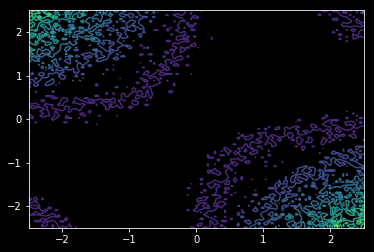

In [12]:
gamma_vec = torch.linspace(-2.5,2.5, 100)
theta_vec = torch.linspace(-2.5,2.5, 100)
M = torch.zeros((len(gamma_vec), len(theta_vec)))

for ig, g in enumerate(gamma_vec):
    for it, t in enumerate(theta_vec):
        pyro.get_param_store().__setitem__("gamma-mean",g)
        pyro.get_param_store().__setitem__("theta-mean",t)
        M[ig,it] = svi.evaluate_loss(x)
plt.contour(gamma_vec, theta_vec,M.round())

In [13]:

import numpy as np
import plotly
import plotly.graph_objs as go
fig = go.Figure(data=[go.Surface(x=gamma_vec,
                   y=theta_vec,
                   z=M.round(),
                  )])
plotly.offline.iplot(fig)


## Plot values ON the optimal line
We plot the elbo loss for different configurations of theta, gamma on the optimal line (2=theta*gamma).
To estimate the loss we sample 10 draws to reduce variance.


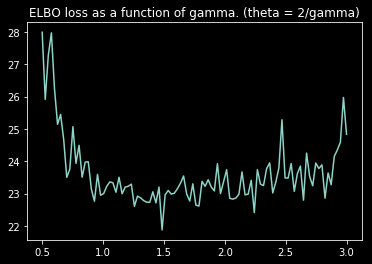

No handles with labels found to put in legend.


Text(0.5, 1.0, 'ELBO LOSS in the (theta,gamma) 2 dim space. Color indicates loss (purple is lower)')

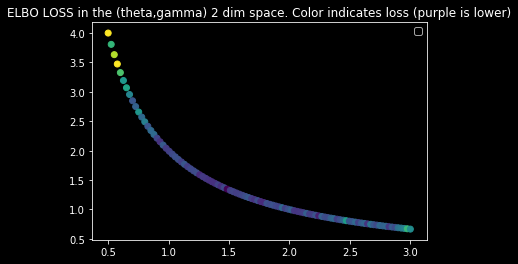

In [14]:
gamma_vec = torch.linspace(0.5,3, 100)
theta_vec = 2/gamma_vec
M = torch.zeros_like(gamma_vec)

for i, (g,t) in enumerate(zip(gamma_vec, theta_vec)):
    pyro.get_param_store().__setitem__("gamma-mean",g)
    pyro.get_param_store().__setitem__("theta-mean",t)
    M[i] = np.mean([svi.evaluate_loss(x) for _ in range(20)]) #svi.evaluate_loss(x)

plt.plot(gamma_vec, M)
plt.title("ELBO loss as a function of gamma. (theta = 2/gamma)")
plt.show()

plt.scatter(gamma_vec, theta_vec, c=M)
plt.legend()
plt.title("ELBO LOSS in the (theta,gamma) 2 dim space. Color indicates loss (purple is lower)")